## Summary

### The data file contains one full day of impression logs for selected IP addresses. The fields are, in order:
1. Timestamp
2. IP address
3. Detected browser type
4. User agent string
5. Domain (URL)
6. Whether the impression was in view (1.0 = yes, 0.0 = no)
7. Number of plugins installed
8. Browser window position and size (x, y, width, height)
9. Network latency

### The task is to identify domains which are receiving a substantial amount of fraudulent traffic. 

### I looked at a bunch of stuff, none of which yielded any distinct signature until I plotted mean time between consecutive visits and number of visits from a particular IP address.   Here you'll see some clustering and distinct outliers.  I believe that this might be a good clustering problem.  See graphs below.



In [202]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

%matplotlib inline

# Read and wrangle data file

In [715]:
first_line_raw = pd.read_csv('fraud.event',delimiter='\t',nrows=3)
first_line_raw

,2014-08-25 00:00:00,101.171.127.230,Safari/Webkit,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/534.59.10 (KHTML, like Gecko) Version/5.1.9 Safari/534.59.10",http://www.domain.com.au,0.0,Unnamed: 6,"(0,0,1280,629)",0
0,2014-08-25 00:00:00,101.171.127.230,Safari/Webkit,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,http://www.domain.com.au,0,NaN,"(0,0,1280,629)",0
1,2014-08-25 00:00:00,71.174.104.12,Unknown,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,http://www.mangareader.net,NaN,NaN,NaN,NaN
2,2014-08-25 00:00:00,71.174.104.12,Unknown,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,http://www.mangareader.net,NaN,NaN,NaN,NaN


In [46]:
first_line_raw.iloc[0].str.split('\t')

2014-08-25 00:00:00\t101.171.127.230\tSafari/Webkit\tMozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/534.59.10 (KHTML, like Gecko) Version/5.1.9 Safari/534.59.10\thttp://www.domain.com.au\t0.0\t\t(0,0,1280,629)\t0    [2014-08-25 00:00:00, 101.171.127.230, Safari/...
dtype: object

In [57]:
columns = ['Timestamp', 'IP_address', 'Browser_type', 'User_agent','URL', 'In_view', 'Plugins', 'Position_size','Latency']
columns

['Timestamp',
 'IP_address',
 'Browser_type',
 'User_agent',
 'URL',
 'In_view',
 'Plugins',
 'Position_size',
 'Latency']

In [646]:
test = pd.read_csv('fraud.event',delimiter='\t',names=columns,header=None)
test.tail(3)

,Timestamp,IP_address,Browser_type,User_agent,URL,In_view,Plugins,Position_size,Latency
235080,2014-08-25 23:59:56,71.59.231.50,Unknown,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4)...,http://pixel.adsafeprotected.com,NaN,NaN,NaN,NaN
235081,2014-08-25 23:59:58,66.188.92.172,Chrome,Mozilla/5.0 (X11; CrOS x86_64 5841.98.0) Apple...,http://www.realtor.com,1,9,NaN,170
235082,2014-08-25 23:59:58,73.166.186.214,Safari/Webkit,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,http://www.viralnova.com,0,1,"(0,0,320,372)",0


# Set up training data

In [610]:
train = pd.Series(['featureplay.com',
'uvidi.com',
'spryliving.com',
'greatxboxgames.com',
'mmabay.co.uk',
'workingmothertv.com',
'besthorrorgame.com',
'dailyparent.com',
'superior-movies.com',
'yourhousedesign.com',
'outdoorlife.tv',
'drumclub.info',
'cycleworld.tv',
'hmnp.us',
'nlinevideos.com'])
#train = (lambda i: train[i].str.cat('http://www.') 
for i in range(len(train)):
    train[i] = 'http://www.' + train[i]

In [625]:
bad_urls_test = test[test.URL.isin(train)].groupby('URL')
bad_urls_test.size()


URL
http://www.featureplay.com    560
http://www.mmabay.co.uk       123
http://www.uvidi.com          294
dtype: int64

### Hmmm... there are only 3 websites we were given that had data...

# Now let's sort this dataframe according to URLs.

In [674]:
sorted_urls = test.groupby('URL').agg(lambda x: list(x)).reset_index()


In [717]:
sorted_urls.tail(3)

,URL,Timestamp,IP_address,Browser_type,User_agent,In_view,Plugins,Position_size,Latency
11776,http://zoomboomerz.deviantart.com,[2014-08-25 23:15:35],[68.106.209.234],[Unknown],[Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...,[nan],[nan],[nan],[nan]
11777,http://zui.scornews.com,"[2014-08-25 11:57:39, 2014-08-25 15:18:07]","[54.183.195.200, 54.183.195.200]","[Internet Explorer, Internet Explorer]",[Mozilla/5.0 (Windows; U; Windows NT 6.1; zh-C...,"[0.0, 0.0]","[nan, nan]","[nan, nan]","[0.0, 0.0]"
11778,http://zynga.com,"[2014-08-25 00:03:41, 2014-08-25 00:07:43, 201...","[184.53.39.213, 184.53.39.213, 151.224.175.1, ...","[Chrome, Chrome, Unknown, Chrome, Chrome, Unkn...",[Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...,"[1.0, 0.0, nan, 1.0, 0.0, nan, 0.0, 0.0, 1.0, ...","[10.0, 10.0, nan, 10.0, 10.0, nan, 7.0, 7.0, 1...","[nan, nan, nan, nan, nan, nan, (16,8,1330,720)...","[0.0, 0.0, nan, 1629.0, 0.0, nan, 0.0, 0.0, 20..."


In [677]:
zillow = sorted_urls[sorted_urls.URL=='http://zillow.com']
zillow


,URL,Timestamp,IP_address,Browser_type,User_agent,In_view,Plugins,Position_size,Latency
11772,http://zillow.com,"[2014-08-25 00:29:46, 2014-08-25 00:35:48, 201...","[72.70.131.182, 72.70.131.182, 72.70.131.182, ...","[Internet Explorer, Internet Explorer, Interne...",[Mozilla/5.0 (compatible; MSIE 9.0; Windows NT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[nan, nan, nan, 16.0, nan, 14.0, nan]","[nan, nan, nan, nan, nan, nan, (-8,-8,1616,876)]","[0.0, 0.0, 0.0, nan, 0.0, 281.0, 261.0]"


In [678]:
len(zillow.IP_address.iloc[0])

7

In [679]:
url_hits = urls.size()
print(url_hits.head(5))
len(url_hits)

URL
ERROR                                                            138
http://%5bfox.com                                                  5
http://.cooks.com/ros/728x90/jx/domain/.cooks.com                  1
http://.dailymotion.com/ros/728x90/jx/domain/.dailymotion.com      1
http://.pandora.com/ros/300x250/jx/domain/.pandora.com             1
dtype: int64


11779

In [680]:
# Take out ERROR line
#url_hits = url_hits.drop('ERROR')
print('Min hits:',url_hits.min(),'Max hits:',url_hits.max(),'Avg hits:',url_hits.mean())
url_hits_sorted = url_hits.sort_values()
print('Sites with most number of visits')
url_hits_sorted.tail(5)

Min hits: 1 Max hits: 20548 Avg hits: 19.957806265387553
Sites with most number of visits


URL
http://www.pandora.com               2949
http://www.ebay.co.uk                3012
http://www.answers.com               3791
http://fw.adsafeprotected.com       11942
http://pixel.adsafeprotected.com    20548
dtype: int64

### Some of these numbers are suspiciously large but some of them may be legitimate due to popularity of websites.  At this point, we don't know.

In [719]:
# Lets take at a couple of the ones with large number of hits.
adsafeprotected=sorted_urls[sorted_urls.URL == 'http://pixel.adsafeprotected.com']
adsafeprotected

,URL,Timestamp,IP_address,Browser_type,User_agent,In_view,Plugins,Position_size,Latency
4100,http://pixel.adsafeprotected.com,"[2014-08-25 00:00:16, 2014-08-25 00:00:21, 201...","[70.194.132.4, 77.105.183.211, 67.2.80.14, 71....","[Safari/Webkit, Safari/Webkit, Internet Explor...",[Mozilla/5.0 (Linux; Android 4.4.4; XT1080 Bui...,"[1.0, 0.0, 1.0, nan, 0.0, 1.0, nan, 0.0, 0.0, ...","[nan, nan, nan, nan, 1.0, 1.0, nan, nan, nan, ...","[(0,0,320,272), nan, nan, nan, (0,0,728,90), (...","[0.0, 0.0, 364.0, nan, 0.0, 0.0, nan, 0.0, nan..."


In [722]:
sorted = adsafeprotected.User_agent.values[0]
print(sorted[0])

from collections import Counter

user_agent_counts = Counter(np.array(sorted))
user_agent_counts.most_common(5)



Mozilla/5.0 (Linux; Android 4.4.4; XT1080 Build/SU4.21) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/33.0.0.0 Mobile Safari/537.36


[('Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36',
  1572),
 ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/536.25 (KHTML, like Gecko) Version/6.0 Safari/536.25',
  1525),
 ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36',
  1158),
 ('Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko', 931),
 ('Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Mobile/11D257',
  745)]

### Nothing suspicious so far

In [683]:
# Now let's look at time intervals between consecutive hits

import datetime
import time

time = adsafeprotected.Timestamp.values[0]
print(time[0])
pydates = np.array(datetime.datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S") )
interval = np.array([])
for i in range(1,len(time)):
    dt = datetime.datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S") 
    pydates = np.append(pydates,dt)
    interval = np.append(interval,(pydates[i]-pydates[i-1]).total_seconds())

#datetime.combine(date.today(), exit) - datetime.combine(date.today(), enter)

2014-08-25 00:00:16


In [684]:
pydates[0]
print(interval[1])
adsafe_pydates = pydates
adsafe_interval = interval

9.0


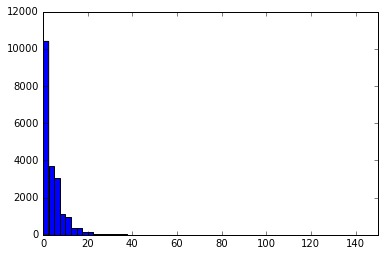

In [685]:
plt.hist(adsafe_interval,bins=50)

axes = plt.gca()
axes.set_xlim([0,150])
plt.show()

### Now let's look at a popular website.

In [686]:
pandora=sorted_urls[sorted_urls.URL == 'http://www.pandora.com']
pandora

,URL,Timestamp,IP_address,Browser_type,User_agent,In_view,Plugins,Position_size,Latency
9685,http://www.pandora.com,"[2014-08-25 00:01:27, 2014-08-25 00:06:46, 201...","[74.76.96.101, 206.192.168.26, 74.76.96.101, 7...","[Internet Explorer, Internet Explorer, Interne...",[Mozilla/5.0 (compatible; MSIE 10.0; Windows N...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, nan, nan, nan, 9.0, 16.0, nan, nan, nan,...","[(0,0,1138,666), (0,0,1659,865), (0,0,1138,666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 0.0,..."


In [687]:
# Time interval module
def time_interval(df):
    time = df.Timestamp.values[0]
#print(time[0])
    pydates = np.array(datetime.datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S") )
    interval = np.array([])
    for i in range(1,len(time)):
        dt = datetime.datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S") 
        pydates = np.append(pydates,dt)
        interval = np.append(interval,(pydates[i]-pydates[i-1]).total_seconds())
    return pydates, interval

In [688]:
pandora_pydates, pandora_interval = time_interval(pandora)

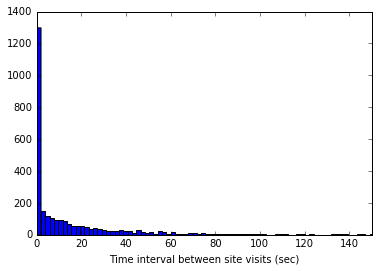

In [689]:
plt.hist(pandora_interval,bins=2000)

axes = plt.gca()
axes.set_xlim([0,150])
axes.set_xlabel('Time interval between site visits (sec)')
plt.show()

### Interestingly, the number of back-back visits to Pandora dwarfs all other time intervals and accounts for half of all the visits in this time period.  So is this something nefarious as well?  

In [690]:
# Let's look at IP addresses first of adsafeprotected.
adsafeprotected_IP = adsafeprotected.IP_address.values[0]
adsafeprotected_IP_common = Counter(adsafeprotected_IP).most_common()
print('Top 3 IP address visits to adsafeprotected')
print(adsafeprotected_IP_common[:3])

Top 3 IP address visits to adsafeprotected
[('96.251.30.244', 1526), ('76.219.64.180', 856), ('206.110.20.2', 808)]


In [691]:
# Now let's look at IP addresses first of pandora.
pandora_IP = pandora.IP_address.values[0]
pandora_IP_common = Counter(pandora_IP).most_common()
print('Top 3 IP address visits to pandora')
print(pandora_IP_common[:3])

Top 3 IP address visits to pandora
[('206.192.168.26', 1903), ('165.138.86.152', 89), ('198.147.17.5', 81)]


In [692]:
#  Are there common IP addresses between the two sets?
IP_intersection=list(set(adsafeprotected_IP).intersection(pandora_IP))
#print(IP_intersection)
pandora_IP_common = pd.DataFrame(pandora_IP_common,columns=['IP_address', 'Hits'])
adsafeprotected_IP_common = pd.DataFrame(adsafeprotected_IP_common,columns=['IP_address', 'Hits'])





In [693]:
pandora_intersection = pandora_IP_common[pandora_IP_common.IP_address.isin(IP_intersection)]
pandora_intersection.head(3)

,IP_address,Hits
0,206.192.168.26,1903
1,165.138.86.152,89
2,198.147.17.5,81


In [694]:
adsafeprotected_intersection = adsafeprotected_IP_common[adsafeprotected_IP_common.IP_address.isin(IP_intersection)]
adsafeprotected_intersection.head(3)

,IP_address,Hits
2,206.110.20.2,808
3,206.192.168.26,379
4,131.107.0.71,261


In [695]:
print('Number of common IP addresses between adsafeprotected and pandora:',len(IP_intersection))

Number of common IP addresses between adsafeprotected and pandora: 75


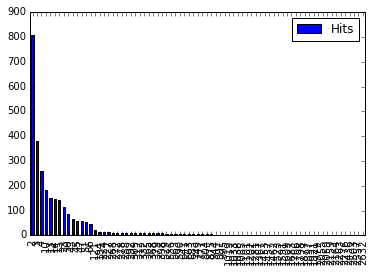

In [696]:
adsafeprotected_intersection.plot(kind='bar',rot=90,label='Common Hits in adsafeprotected')
plt.show()

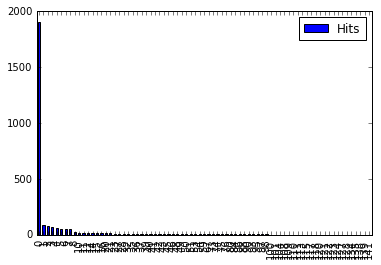

In [697]:
pandora_intersection.plot(kind='bar',rot=90)
plt.show()

### At this point, it would be good to cross-correlate these IP addresses with the time interval series to see if there are any commonalities

Top 3 IP address visits to featureplay
[('173.74.71.189', 126), ('23.120.117.39', 85), ('173.55.201.175', 64)]


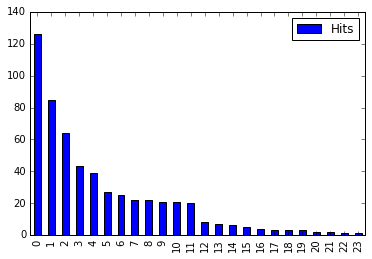

In [698]:
# Now lets take a look at one of the test cases, http://www.featureplay.com'adsafeprotected_IP = adsafeprotected.IP_address.values[0]
featureplay=sorted_urls[sorted_urls.URL == 'http://www.featureplay.com']
featureplay_IP = featureplay.IP_address.values[0]
featureplay_IP_common = Counter(featureplay_IP).most_common()
print('Top 3 IP address visits to featureplay')
print(featureplay_IP_common[:3])
featureplay_IP_common = pd.DataFrame(featureplay_IP_common,columns=['IP_address', 'Hits'])
featureplay_IP_common.plot(kind='bar',rot=90)

In [699]:
# Now let's write a time interval module that calculates time intervals between hits from the same IP address
def time_interval_address(df):
    time = df.Timestamp.values[0]
    address = df.IP_address.values[0]
    new_df = pd.DataFrame({'Timestamp':time,'IP_address':address}).sort_values('IP_address')
    grouped_address = new_df.IP_address
    grouped_time = new_df.Timestamp

    pydates = np.array(datetime.datetime.strptime(grouped_time[0], "%Y-%m-%d %H:%M:%S") )
    interval = np.nan
    for i in range(1,len(time)):
        dt = datetime.datetime.strptime(grouped_time[i], "%Y-%m-%d %H:%M:%S") 
        pydates = np.append(pydates,dt)
        if grouped_address[i]==grouped_address[i-1]:
           interval = np.append(interval,(pydates[i]-pydates[i-1]).total_seconds())
        else:
            interval = np.append(interval,np.nan)
            
    return pd.DataFrame({'IP_address':grouped_address, 'Timestamp':pydates, 'Time_delta':interval})

In [700]:
featureplay_address_time = time_interval_address(featureplay)

In [701]:
featureplay_address_time.head(3)

,IP_address,Time_delta,Timestamp
391,173.208.33.229,NaN,2014-08-25 00:37:25
389,173.208.33.229,NaN,2014-08-25 01:05:18
387,173.208.33.229,2445,2014-08-25 01:46:03


,Time_delta
IP_address,
173.208.33.229,2445.000000
173.55.201.175,142.386364
173.56.25.16,61.000000


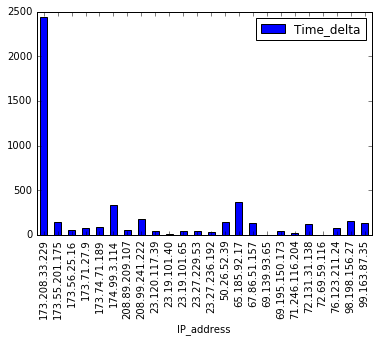

In [702]:
featureplay_address_time.groupby('IP_address').mean().plot(kind='bar')
featureplay_address_time.groupby('IP_address').mean().head(3)

In [706]:
#Throw out the big number.
featureplay_address_time_trimmed=featureplay_address_time[featureplay_address_time.Time_delta<500]

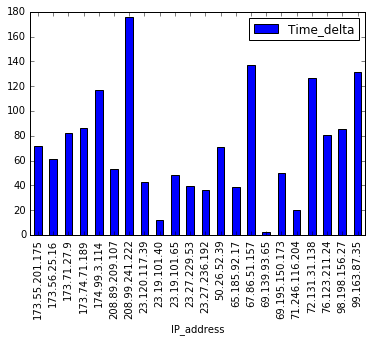

In [707]:
featureplay_address_time_trimmed.groupby('IP_address').mean().plot(kind='bar')
plt.show()

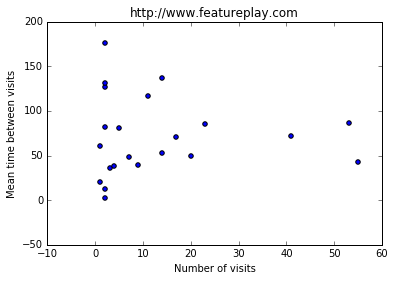

In [714]:
plt.scatter(featureplay_address_time_trimmed.groupby('IP_address').size(),featureplay_address_time_trimmed.groupby('IP_address').mean())

axes = plt.gca()
axes.set_xlabel('Number of visits')
axes.set_ylabel('Mean time between visits')
axes.set_title('http://www.featureplay.com')
plt.show()

## Ah hah!  Now we have some data that is showing distinct clusters and outliers...  Getting warmer.

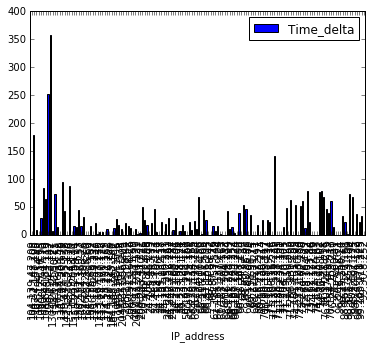

In [601]:
# Now let's go back to Pandora
pandora_address_time = time_interval_address(pandora)
pandora_address_time.groupby('IP_address').mean().plot(kind='bar')
plt.show()

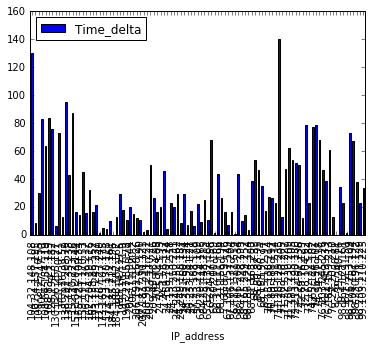

In [602]:
#Throw out big number.
pandora_address_time_trimmed=pandora_address_time[pandora_address_time.Time_delta<500]
pandora_address_time_trimmed.groupby('IP_address').mean().plot(kind='bar')
plt.show()


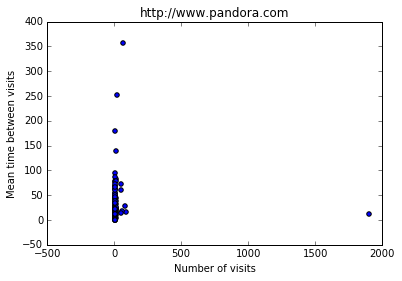

In [713]:
plt.scatter(pandora_address_time.groupby('IP_address').size(),pandora_address_time.groupby('IP_address').mean())
axes = plt.gca()
axes.set_xlabel('Number of visits')
axes.set_ylabel('Mean time between visits')
axes.set_title('http://www.pandora.com')
plt.show()

## Oh ho ho!  Look at that one little dot way the heck to the right.  Large number of visits (close to 2000) with near zero mean time between each hit.  But this is Pandora!  We are getting hot...

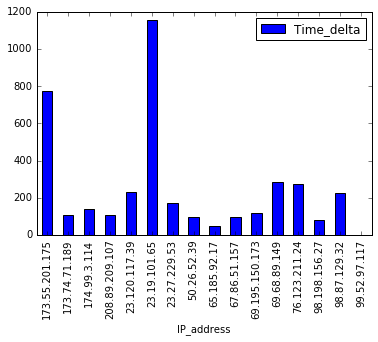

In [709]:
# Now lets take a look at another one of the test cases, http://www.uvidi.com
uvidi=sorted_urls[sorted_urls.URL == 'http://www.uvidi.com']
uvidi_address_time = time_interval_address(uvidi)
uvidi_address_time.groupby('IP_address').mean().plot(kind='bar')
plt.show()

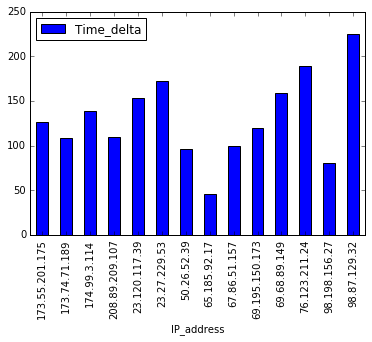

In [710]:
#Throw out big numbers.
uvidi_address_time_trimmed=uvidi_address_time[uvidi_address_time.Time_delta<500]
uvidi_address_time_trimmed.groupby('IP_address').mean().plot(kind='bar')
plt.show()

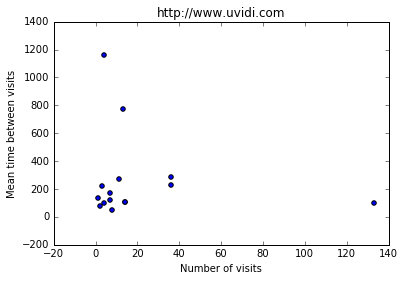

In [712]:
plt.scatter(uvidi_address_time.groupby('IP_address').size(),uvidi_address_time.groupby('IP_address').mean())
axes = plt.gca()
axes.set_xlabel('Number of visits')
axes.set_ylabel('Mean time between visits')
axes.set_title('http://www.uvidi.com')
plt.show()

## Another one of the training sets shows outliers as well.  

In [353]:
#  Let's take a look at the overall distribution of number of hits in this given time frame
url_hits.tail(3)

URL
http://www.answers.com               3791
http://fw.adsafeprotected.com       11942
http://pixel.adsafeprotected.com    20548
dtype: int64

In [348]:

# normalized with logx.
url_hits_norm = url_hits.apply(math.log)
#url_hits_norm = math.log([float(url_hits.values)])

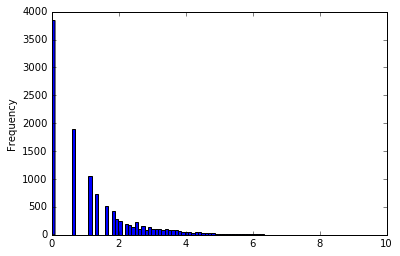

In [354]:
# Distribution of log(number of hits)
url_hits_norm.plot(kind='hist',bins=100)
plt.show()


In [359]:
print('Norm avg hits:', math.log(url_hits.mean()))

Norm avg hits: 2.9931180596763562


### This is a strongly left-skewed distribution where the average number of hits (normalized) is about 3 (so about 20 hits).  